In [1]:
import numpy as np
import random
import datetime
import matplotlib.pyplot as plt
from itertools import chain, combinations

from Hypergraph_Product_Code_Construction_v3 import HGP_code
from peeling_cluster_decoder import combined_peeling_and_cluster_decoder
from utilities import generate_erasure_pattern_index_set, generate_random_H_matrix, HGP_code, generate_random_error_index_set_with_erasure_support

In [2]:
def randomly_assign_qubits_to_photons(num_multiplexing,num_photons):
    num_qubits = num_multiplexing * num_photons
    qubits = [i for i in range(num_qubits)]
    photons = []
    
    for j in range(num_photons):
        qubits_in_photon = []
        for k in range(num_multiplexing):
            picked_qubit = random.choice(qubits)
            qubits_in_photon.append(picked_qubit)
            qubits.remove(picked_qubit)
        photons.append(qubits_in_photon)    
    return photons

In [3]:
def deterministically_assign_qubits_to_photons(num_multiplexing,num_photons):
    num_qubits = num_multiplexing * num_photons
    qubits = [i for i in range(num_qubits)]
    photons = []
    
    for j in range(num_photons):
        qubits_in_photon = []
        for k in range(num_multiplexing):
            picked_qubit = qubits[0]
            qubits_in_photon.append(picked_qubit)
            qubits.remove(picked_qubit)
        photons.append(qubits_in_photon)    
    return photons

In [4]:
def make_erasure_vec_from_ph(assignment, erasure_pattern):
    erased_qubits = []
    erasure_pattern = list(erasure_pattern)
    
    for index in erasure_pattern:
        erased_qubits  = erased_qubits + assignment[index]
    return erased_qubits

In [5]:
def get_success_prob(HGP, assignment, num_trials, num_photons, erasure_rate):
    num_success = 0
    num_failure = 0
    trials = 0
    while trials < num_trials:
        trials += 1
        try:
            errors_on_photons = generate_erasure_pattern_index_set(num_photons, erasure_rate)
            erasure_on_qubits = make_erasure_vec_from_ph(assignment = assignment, erasure_pattern = errors_on_photons)
            # print('erasure_on_qubits:')
            # print(erasure_on_qubits)
            random_pauli = generate_random_error_index_set_with_erasure_support(HGP.num_qubits, erasure_index_set = set(erasure_on_qubits),error_rate = erasure_rate)
            # print('random_pauli:')
            # print(random_pauli)
            syndrome = HGP.Hz_syn_index_set_for_X_err(random_pauli)
            result = combined_peeling_and_cluster_decoder(HGP_code=HGP,E_index_set_input=set(erasure_on_qubits),s_index_set_input=syndrome)

            if HGP.is_non_trivial_X_logical_error_index_set(result[0]) == False:
                num_success += 1
            else:
                num_failure += 1
        except:
            # print("Decoder failed to decode")
            num_failure += 1
    res_trials = [num_success, num_failure]
    # print('results:' + str(res_trials))
    return res_trials

In [6]:
def agresti_coull_intetrval(pair):
    # num trial n
    success = pair[0]
    fail = pair[1]
    rate = success / (success + fail)
    n = success + fail
    z = 2
    n_tilda = n  + z ** 2
    p_tilda = (1 / n_tilda) * (success + (z**2/2) )
    # conf_int_min = p_tilda + (z * (np.sqrt(  (p_tilda / n_tilda) * (1 - p_tilda) )))
    # conf_int_max = p_tilda - (z * (np.sqrt(  (p_tilda / n_tilda) * (1 - p_tilda) )))
    dif = (z * (np.sqrt(  (p_tilda / n_tilda) * (1 - p_tilda) )))
    # return [conf_int_min, rate, conf_int_max]
    # dif = conf_int_max - conf_int_min 
    return dif

In [15]:
def rate_and_error(results, num):
    rates = []
    errors = []
    for i in range(num):
        num_success = results[i][0]
        num_fail = results[i][1]
        rate = num_fail / (num_success + num_fail)
        rates.append(rate)
        error = agresti_coull_intetrval([num_success, num_fail])
        errors.append(error)
    return rates, errors

In [7]:
H1 = generate_random_H_matrix(total_bits= 4,bit_node_deg=4,check_node_deg=2)
H2 = generate_random_H_matrix(total_bits= 4,bit_node_deg=4,check_node_deg=2)
HGP = HGP_code(H1,H2)
print('HGP.num_qubits:' + str(HGP.num_qubits))
erasure_rates = [0 + 0.01 * i for i in range(50)]

dt_now = datetime.datetime.now()
print(dt_now)

random_assignment = randomly_assign_qubits_to_photons(2,40)
print('assignment:' + str(random_assignment))
res_HGP_random = []
for i in erasure_rates:
    res_trials = get_success_prob(HGP=HGP, assignment=random_assignment, num_trials = 100000, num_photons = 40, erasure_rate = i)
    # print(str(i) + ':' + str(res_trials))
    res_HGP_random.append(res_trials)

dt_now = datetime.datetime.now()
print(dt_now)
    
deterministic_assignment = deterministically_assign_qubits_to_photons(2,40)
print('assignment:' + str(deterministic_assignment))
res_HGP_deterministic = []
for i in erasure_rates:
    res_trials = get_success_prob(HGP=HGP, assignment=deterministic_assignment, num_trials = 100000, num_photons = 40, erasure_rate = i)
    # print(str(i) + ':' + str(res_trials))
    res_HGP_deterministic.append(res_trials)

dt_now = datetime.datetime.now()
print(dt_now)

assignment_without_qm = deterministically_assign_qubits_to_photons(1,80)
print('assignment:' + str(assignment_without_qm))
res_HGP_without_qm = []
for i in erasure_rates:
    res_trials = get_success_prob(HGP=HGP, assignment=assignment_without_qm, num_trials = 100000, num_photons = 80, erasure_rate = i)
    # print(str(i) + ':' + str(res_trials))
    res_HGP_without_qm.append(res_trials)

HGP.num_qubits:80
2024-03-07 00:53:23.739310
assignment:[[75, 32], [21, 0], [29, 34], [65, 24], [36, 48], [77, 22], [40, 8], [54, 6], [73, 58], [3, 64], [47, 39], [50, 41], [62, 43], [60, 18], [11, 35], [45, 79], [71, 68], [74, 51], [10, 66], [28, 17], [38, 5], [25, 1], [53, 27], [42, 78], [76, 12], [33, 70], [19, 30], [16, 31], [4, 9], [46, 20], [57, 69], [44, 7], [72, 59], [52, 2], [67, 63], [61, 26], [13, 23], [56, 49], [14, 37], [15, 55]]
2024-03-07 02:54:26.995799
assignment:[[0, 1], [2, 3], [4, 5], [6, 7], [8, 9], [10, 11], [12, 13], [14, 15], [16, 17], [18, 19], [20, 21], [22, 23], [24, 25], [26, 27], [28, 29], [30, 31], [32, 33], [34, 35], [36, 37], [38, 39], [40, 41], [42, 43], [44, 45], [46, 47], [48, 49], [50, 51], [52, 53], [54, 55], [56, 57], [58, 59], [60, 61], [62, 63], [64, 65], [66, 67], [68, 69], [70, 71], [72, 73], [74, 75], [76, 77], [78, 79]]
2024-03-07 04:54:09.161074
assignment:[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15],

In [8]:
print(res_HGP_random)
print('--------------')
print(res_HGP_deterministic)
print('--------------')
print(res_HGP_without_qm)

[[100000, 0], [100000, 0], [100000, 0], [100000, 0], [100000, 0], [100000, 0], [99999, 1], [99995, 5], [99992, 8], [99980, 20], [99949, 51], [99913, 87], [99851, 149], [99759, 241], [99608, 392], [99397, 603], [99075, 925], [98688, 1312], [98195, 1805], [97568, 2432], [96651, 3349], [95617, 4383], [94385, 5615], [92893, 7107], [91031, 8969], [89047, 10953], [86813, 13187], [84148, 15852], [81280, 18720], [78108, 21892], [74938, 25062], [71239, 28761], [67659, 32341], [63740, 36260], [59714, 40286], [55778, 44222], [51383, 48617], [47285, 52715], [43125, 56875], [39121, 60879], [35331, 64669], [31574, 68426], [28064, 71936], [24782, 75218], [21964, 78036], [18957, 81043], [16537, 83463], [14031, 85969], [12106, 87894], [10142, 89858]]
[[100000, 0], [100000, 0], [100000, 0], [100000, 0], [99998, 2], [99996, 4], [99993, 7], [99983, 17], [99961, 39], [99912, 88], [99837, 163], [99716, 284], [99614, 386], [99344, 656], [99034, 966], [98574, 1426], [98045, 1955], [97516, 2484], [96532, 3468]

In [21]:
rate_HGP_random, error_HGP_random = rate_and_error(res_HGP_random, 50)
rate_HGP_deterministic, error_HGP_deterministic = rate_and_error(res_HGP_deterministic, 50)
rate_HGP_without_qm, error_HGP_without_qm = rate_and_error(res_HGP_without_qm, 50)

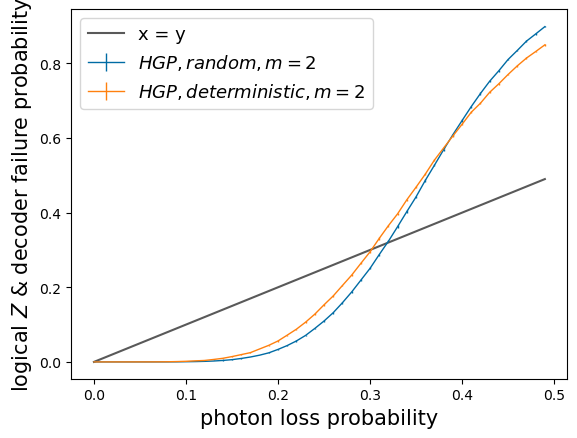

In [23]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.errorbar(erasure_rates, rate_HGP_random, error_HGP_random, label = r'$HGP, random, m=2$', color = 'C0', linewidth= 1)
ax.errorbar(erasure_rates, rate_HGP_deterministic, error_HGP_deterministic, label = r'$HGP, deterministic, m=2$', color = 'C1', linewidth= 1)
# ax.errorbar(erasure_rates, rate_HGP_without_qm, error_HGP_without_qm, label = r'$HGP, m=1$', color = 'C5', linewidth= 1)

ax.plot(erasure_rates, erasure_rates, color = 'C3', label= "x = y")
# ax.set_yscale('log')
ax.set_xlabel("photon loss probability", fontsize = 15)
ax.set_ylabel(r"logical $Z$ & decoder failure probability", fontsize = 15)
# ax.set_xlim(0.30x, 0.55)

# ax.set_title(r"$10\times 10$ toric codes", fontsize = 15)
# ax.set_facecolor('lightgrey')
plt.style.use('tableau-colorblind10')
plt.legend(loc='upper left', fontsize = 13)
# plt.savefig("10_10_multiplexed_toric_minmax.pdf")
plt.savefig("multiplexed_HGP_random.pdf")
plt.show()